来源：[b站刘二大人-RNN高级篇](https://www.bilibili.com/video/BV1Y7411d7Ys?t=3&p=13)
## model
![model](https://ericpengshuai.github.io/pic/model.png)


### 准备数据
1. 对于每个名字需要得到一个向量
2. 通过ASCII对于每个名字的每个字符都得到一个`one-hot vector`
![data](https://ericpengshuai.github.io/pic/data.png)

3. 由于输入是矩阵所以需要`padding`


In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gzip
import csv

class NameDataset(Dataset):
    def __init__(self, is_train_set):
        filename = '../dataset/names_train.csv.gz' if is_train_set else '../dataset/names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:    # r表示只读，从文件头开始 t表示文本模式
            reader = csv.reader(f)
            rows = list(reader)
        self.names = [row[0] for row in rows]
        self.len = len(self.names)
        self.countries = [row[1] for row in rows]

        self.country_list = list(sorted(set(self.countries)))
        self.country_dict = self.getCountryDict()
        self.country_num = len(self.country_list)

    def __getitem__(self, index):       # 根据索引拿到的是 名字，国家的索引
        return self.names[index], self.country_dict[self.countries[index]]

    def __len__(self):
        return self.len

    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict

    def idx2country(self, index):
        return self.country_list[index]

    def getCountriesNum(self):
        return self.country_num

HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 50
N_CHARS = 128   # 这个是为了构造嵌入层

trainSet = NameDataset(is_train_set=True)
trainLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True)
testSet = NameDataset(is_train_set=False)
testLoader = DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False)

N_COUNTRY = trainSet.getCountriesNum()

In [2]:
for idx, (names, countries) in enumerate(trainLoader):
    print(names.__len__(), type(countries), countries.shape)
    if idx == 0:
        break

256 <class 'torch.Tensor'> torch.Size([256])


### 构建模型
#### GRU的维度
1. 输入维度
- 𝑖𝑛𝑝𝑢𝑡: (𝑠𝑒𝑞𝐿𝑒𝑛, 𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒, ℎ𝑖𝑑𝑑𝑒𝑛𝑆𝑖𝑧𝑒) 
- hidden: (nLayers * nDirections, batchSize, hiddenSize)
2. 输出维度
- output: (seqLen, batchSize, hiddenSize * nDirections)
- hidden: (nLayers * nDirections, batchSize, hiddenSize)
3. 示意图  
![model示意图](https://ericpengshuai.github.io/pic/model-show.png)

#### GRU处理时可以使用`pack_padded_sequence`提高效率
![pack_padded](https://ericpengshuai.github.io/pic/pack_padded_sequence.png)

In [3]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__() 
        self.hidden_size = hidden_size 
        self.n_layers = n_layers 
        self.n_directions = 2 if bidirectional else 1   # 使用双向的GRU
        
        # 嵌入层（𝑠𝑒𝑞𝐿𝑒𝑛, 𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒） --> (𝑠𝑒𝑞𝐿𝑒𝑛, 𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒, hidden_size)
        self.embedding = torch.nn.Embedding(input_size, hidden_size) 
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional) 
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size) 
        return hidden

    def forward(self, x_input, seq_lengths):
        # x_input shape : B x S -> S x B
        x_input = x_input.t()
        batch_size = x_input.size(1)
        hidden = self._init_hidden(batch_size) 
        embedding = self.embedding(x_input)

        # pack them up
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedding, seq_lengths)
        output, hidden = self.gru(gru_input, hidden) 
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        fc_output = self.fc(hidden_cat) 
        return fc_output
    

### 数据转化成Tensor

In [4]:
def name2list(name):
    arr = [ord(c) for c in name]
    return arr, len(arr)

def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names]
    name_sequences = [s1[0] for s1 in sequences_and_lengths]
    seq_lengths = torch.LongTensor([s1[1] for s1 in sequences_and_lengths])
    countries = countries.long()

    # make tensor of name, BatchSize * seqLen
    # 他这里补零的方式先将所有的0 Tensor给初始化出来，然后在每行前面填充每个名字
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    # print("seq_lengths.max:", seq_lengths.max())
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # sort by length to use pack_padded_sequence
    # 将名字长度降序排列，并且返回降序之后的长度在原tensor中的小标perm_idx
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    # 这个Tensor中的类似于列表中切片的方法神奇啊，直接返回下标对应的元素，相等于排序了
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]

    # 返回排序之后名字Tensor，排序之后的名字长度Tensor，排序之后的国家名字Tensor
    return seq_tensor, seq_lengths, countries

### 训练数据

In [5]:
classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER) 

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

import time
import math

def trainModel():
    def time_since(since):
        s = time.time() - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    total_loss = 0 
    for i, (names, countries) in enumerate(trainLoader, 1):
        # print(type(names), type(countries))
        # print(len(names), countries.shape)
        inputs, seq_lengths, target = make_tensors(names, countries)
        
        output = classifier(inputs, seq_lengths) 
        # print("Shape:", output.shape, target.shape)
        # 注意输出和目标的维度：Shape: torch.Size([256, 18]) torch.Size([256])
        loss = criterion(output, target) 
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        total_loss += loss.item() 
        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch} ', end='')
            print(f'[{i * len(inputs)}/{len(trainSet)}] ', end='')
            print(f'loss={total_loss / (i * len(inputs))}') 
    return total_loss

def testModel():
    correct = 0
    total = len(testSet)
    print("evaluating trained model ... ")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testLoader):
            inputs, seq_lengths, target = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            # 注意这个keepdim的使用，为了直接和target计算loss
            pred = output.max(dim=1, keepdim=True)[1]
            # 注意这个view_as 和 eq
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        percent = '%.2f' % (100 * correct / total) 
        print(f'Test set: Accuracy {correct}/{total} {percent}%')

    return correct / total

In [61]:
N_EPOCHS = 50
start = time.time() 
print("Training for %d epochs..." % N_EPOCHS) 
acc_list = [] 
for epoch in range(1, N_EPOCHS + 1):
    # Train cycle
    trainModel() 
    acc = testModel() 
    acc_list.append(acc)

Training for 50 epochs...
 2s] Epoch 1 [2560/13374] loss=0.00895661092363298
 4s] Epoch 1 [5120/13374] loss=0.007739758561365306
 6s] Epoch 1 [7680/13374] loss=0.0069853457777450485
 8s] Epoch 1 [10240/13374] loss=0.006530495395418256
 11s] Epoch 1 [12800/13374] loss=0.006135637713596225
evaluating trained model ... 
Test set: Accuracy 4535/6700 67.69%
 15s] Epoch 2 [2560/13374] loss=0.004228085093200207
 17s] Epoch 2 [5120/13374] loss=0.0041014277492649855
 19s] Epoch 2 [7680/13374] loss=0.004011582878107826
 22s] Epoch 2 [10240/13374] loss=0.0038964587613008915
 24s] Epoch 2 [12800/13374] loss=0.0038181920163333416
evaluating trained model ... 
Test set: Accuracy 4979/6700 74.31%
 28s] Epoch 3 [2560/13374] loss=0.003288307460024953
 31s] Epoch 3 [5120/13374] loss=0.003178741259034723
 34s] Epoch 3 [7680/13374] loss=0.0031318385930111012
 36s] Epoch 3 [10240/13374] loss=0.003077746124472469
 39s] Epoch 3 [12800/13374] loss=0.00303727344609797
evaluating trained model ... 
Test set: Ac

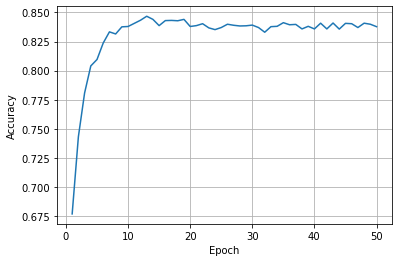

In [62]:
import matplotlib.pyplot as plt
import numpy as np

epoch = np.arange(1, len(acc_list) + 1)
acc_list = np.array(acc_list)
plt.plot(epoch, acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()